In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [2]:
def groupbyDate(df):
    
    dates = list(set(df['time_gmt_date'].to_list()))
    
    rows = []
    
    for dt in dates:
        
        df_date = df[df['time_gmt_date']==dt]
        text = ""
        
        for i in range(df_date.shape[0]):
            text = text+" "+df_date['title'].iloc[i]
            
        rows.append([dt, text])
    
    df_ = pd.DataFrame(rows)
    df_.columns=["date","combined_text"]
    df_.sort_values(by='date', ascending=True, inplace=True)
    
    return df_

def encode_price_direction(df):
    
    for i in range(df.shape[0]):
        
        val = df['price_direction'].iloc[i]
        
        if val == 'up':
            df['price_direction'].iloc[i] = 1
        else: 
            df['price_direction'].iloc[i] = 0
            
    return df

def align_date(df):
    
    for i in range(df.shape[0]):
        x = df['date'].iloc[i]
        x = datetime.strptime(x,"%Y-%m-%d")
        x = x-timedelta(hours=24) 
        df['date'].iloc[i] = x
    return df

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

def plotLossCurve(estimator):
    # Plot model loss over epochs
    plt.plot(estimator.history['loss'])
    plt.plot(estimator.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
def mlp_pretrained_glove_embedding(X_train,X_test,y_train,y_test,epochs):
    
    embeddings_index = {}
    f = open('Model/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    vocab_size = 5000
    oov_token = "<OOV>"
    max_length = 100
    padding_type = "post"
    trunction_type="post"

    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(X_train)
    
    word_index = tokenizer.word_index
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    
    X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)
    
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)
    
    embedding_matrix = np.zeros((len(word_index) + 1, max_length))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                max_length,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    estimator = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, verbose=1)

    plotLossCurve(estimator)

    loss, auc = model.evaluate(X_test_padded,y_test)
    print('Test AUC is {} '.format(auc))
    
def lstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs):

    embeddings_index = {}
    f = open('Model/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    vocab_size = 5000
    oov_token = "<OOV>"
    max_length = 100
    padding_type = "post"
    trunction_type="post"

    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(X_train)
    
    word_index = tokenizer.word_index
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    
    X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)
    
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)
    
    embedding_matrix = np.zeros((len(word_index) + 1, max_length))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,)

    embedding_dim = 16
    input_length = 100

    embedding_layer = Embedding(len(word_index) + 1,
                                max_length,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False)

    model = Sequential([
      embedding_layer,
      LSTM(embedding_dim,),
      Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    estimator = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, verbose=1, callbacks=[early_stopping])

    plotLossCurve(estimator)

    loss, auc = model.evaluate(X_test_padded,y_test)
    print('Test AUC is {} '.format(auc))

    
def bilstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs):

    embeddings_index = {}
    f = open('Model/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    
    vocab_size = 5000
    oov_token = "<OOV>"
    max_length = 100
    padding_type = "post"
    trunction_type="post"

    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(X_train)
    
    word_index = tokenizer.word_index
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    
    X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunction_type)
    
    X_test_sequences = tokenizer.texts_to_sequences(X_test)
    X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunction_type)
    
    embedding_matrix = np.zeros((len(word_index) + 1, max_length))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,)

    embedding_dim = 16
    input_length = 100

    embedding_layer = Embedding(len(word_index) + 1,
                                max_length,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False)

    model = Sequential([
      embedding_layer,
      Bidirectional(LSTM(embedding_dim,)),
      Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    estimator = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, verbose=1, callbacks=[early_stopping])

    plotLossCurve(estimator)

    loss, auc = model.evaluate(X_test_padded,y_test)
    print('Test AUC is {} '.format(auc))

In [4]:
df_news = pd.read_csv('Data/news_data.csv')
df_combined_news = groupbyDate(df_news)
df_combined_news.head()

,date,combined_text
1575,2015-12-28,carl icahn trumps bridgestone s offer for pep...
109,2015-12-29,china to wait and see if japan sincere on com...
261,2015-12-30,south korean comfort women protest against ac...
257,2015-12-31,vw scandal could kill u s diesel car market c...
238,2016-01-01,airbus to sell three a380 superjumbo jets to ...


In [5]:
df_usdjpy = pd.read_csv('Data/usdjpy_daily.csv')
df_usdjpy = encode_price_direction(df_usdjpy)
df_usdjpy.head()

/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,price,price_direction
0,2016-01-01,120.2665,1
1,2016-01-02,120.8575,1
2,2016-01-03,113.9180,0
3,2016-01-04,111.6515,0
4,2016-01-05,106.4375,0


In [6]:
df_usdjpy_ = align_date(df_usdjpy)
df_usdjpy_.head()

/Users/sheetalpandrekar/opt/miniconda3/envs/forextrade/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,price,price_direction
0,2015-12-31 00:00:00,120.2665,1
1,2016-01-01 00:00:00,120.8575,1
2,2016-01-02 00:00:00,113.9180,0
3,2016-01-03 00:00:00,111.6515,0
4,2016-01-04 00:00:00,106.4375,0


In [7]:
df_combined_news['date'] = pd.to_datetime(df_combined_news['date'])
df_usdjpy_['date'] = pd.to_datetime(df_usdjpy_['date'])
df_merged = df_combined_news.merge(df_usdjpy_, on =['date'])
df_merged.head()

,date,combined_text,price,price_direction
0,2015-12-31,vw scandal could kill u s diesel car market c...,120.2665,1
1,2016-01-01,airbus to sell three a380 superjumbo jets to ...,120.8575,1
2,2016-01-03,japan central bank turns activist investor to...,111.6515,0
3,2016-01-05,automakers not silicon valley lead in driverl...,109.4655,1
4,2016-01-06,japanese u s leaders phone talks over north k...,102.5240,0


In [20]:
df_merged.shape

(1719, 4)

Epoch 1/100
35/35 [==============================] - 26s 34ms/step - loss: 0.7106 - auc: 0.5502 - val_loss: 0.7551 - val_auc: 0.4870
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 0.5090 - auc: 0.8753 - val_loss: 0.7667 - val_auc: 0.4811
Epoch 3/100
35/35 [==============================] - 0s 3ms/step - loss: 0.4236 - auc: 0.9358 - val_loss: 0.7473 - val_auc: 0.5140
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 0.3609 - auc: 0.9690 - val_loss: 0.7619 - val_auc: 0.5073
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 0.3174 - auc: 0.9824 - val_loss: 0.7813 - val_auc: 0.5128
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 0.2877 - auc: 0.9866 - val_loss: 0.8018 - val_auc: 0.5047
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 0.2577 - auc: 0.9923 - val_loss: 0.8207 - val_auc: 0.5111
Epoch 8/100
35/35 [==============================] - 0s 6ms/step - loss: 0.2353 -

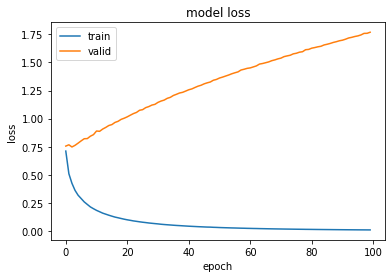

11/11 [==============================] - 0s 2ms/step - loss: 1.7620 - auc: 0.4882
Test AUC is 0.48817071318626404 


In [8]:
X = df_merged['combined_text']
y = df_merged[['price_direction']]

X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [ ]:
epochs = 100
mlp_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

Epoch 1/20
35/35 [==============================] - 6s 70ms/step - loss: 0.6936 - auc: 0.5051 - val_loss: 0.6853 - val_auc: 0.5236
Epoch 2/20
35/35 [==============================] - 1s 39ms/step - loss: 0.6865 - auc: 0.5052 - val_loss: 0.6851 - val_auc: 0.5190
Epoch 3/20
35/35 [==============================] - 2s 44ms/step - loss: 0.6841 - auc: 0.5186 - val_loss: 0.6853 - val_auc: 0.5047
Epoch 4/20
35/35 [==============================] - 2s 47ms/step - loss: 0.6817 - auc: 0.5135 - val_loss: 0.6849 - val_auc: 0.5087
Epoch 5/20
35/35 [==============================] - 2s 47ms/step - loss: 0.6789 - auc: 0.5355 - val_loss: 0.6882 - val_auc: 0.5065
Epoch 6/20
35/35 [==============================] - 1s 42ms/step - loss: 0.6767 - auc: 0.5381 - val_loss: 0.6871 - val_auc: 0.5157
Epoch 7/20
35/35 [==============================] - 2s 45ms/step - loss: 0.6739 - auc: 0.5484 - val_loss: 0.6898 - val_auc: 0.5419
Epoch 8/20
35/35 [==============================] - 2s 44ms/step - loss: 0.6695 - a

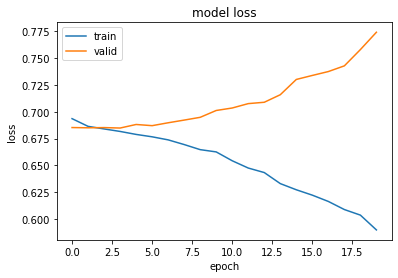

11/11 [==============================] - 0s 10ms/step - loss: 0.7737 - auc: 0.4927
Test AUC is 0.4927465319633484 


In [15]:
epochs = 20
lstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)

Epoch 1/50
35/35 [==============================] - 7s 92ms/step - loss: 0.7107 - auc: 0.4435 - val_loss: 0.6890 - val_auc: 0.4947
Epoch 2/50
35/35 [==============================] - 2s 51ms/step - loss: 0.6869 - auc: 0.5159 - val_loss: 0.6886 - val_auc: 0.5011
Epoch 3/50
35/35 [==============================] - 2s 52ms/step - loss: 0.6808 - auc: 0.5618 - val_loss: 0.6892 - val_auc: 0.5036
Epoch 4/50
35/35 [==============================] - 2s 54ms/step - loss: 0.6753 - auc: 0.6013 - val_loss: 0.6904 - val_auc: 0.4875
Epoch 5/50
35/35 [==============================] - 2s 57ms/step - loss: 0.6684 - auc: 0.6367 - val_loss: 0.6915 - val_auc: 0.5029
Epoch 6/50
35/35 [==============================] - 2s 59ms/step - loss: 0.6622 - auc: 0.6522 - val_loss: 0.6945 - val_auc: 0.4978
Epoch 7/50
35/35 [==============================] - 2s 61ms/step - loss: 0.6526 - auc: 0.6763 - val_loss: 0.6972 - val_auc: 0.5050
Epoch 8/50
35/35 [==============================] - 2s 55ms/step - loss: 0.6436 - a

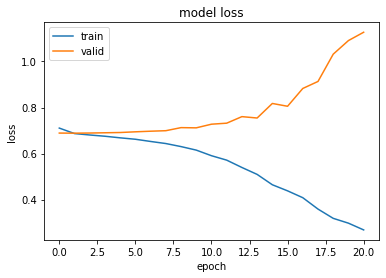

11/11 [==============================] - 0s 17ms/step - loss: 0.6848 - auc: 0.5776
Test AUC is 0.5776361227035522 


In [19]:
epochs = 50
bilstm_pretrained_glove_embedding(X_train,X_test,y_train,y_test, epochs)